# Bsic Analysis

## Dataset

Used four USD based currency exchange rates as follows:

- EUR/USD
- JPY/USD
- CAD/USD
- AUD/USD

100 days to 03/01/2019

## topics

1. Calculate and Visualize the pearson correlations for each pairs
2. Calculate the Value at Risks
3. Predict the future plice and the value at risk of EUR/USD in 100 days by monte carlo simulation based on the brown movement

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from oandaapi import get_exrate_as_df, get_exrate_USD

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

## Getting dataset

Use *daily based* candle data, but focused on only the *closing plice* in this time.

In [2]:
currencies = ['EUR',  'JPY', 'CAD', 'AUD']
currency_pairs = [currency+'_USD' for currency in currencies]

In [3]:
dfs = {
    currency+'_USD' : get_exrate_USD(pair=currency, to='2019-03-01', count=100) 
    for currency in currencies
}

In [4]:
closing_df = pd.DataFrame()
for currency in currencies:
    closing_df[currency+'_USD'] = dfs[currency+'_USD']['close']
closing_df
closing_df.tail()

,EUR_USD,JPY_USD,CAD_USD,AUD_USD
time,,,,
2019-02-24 22:00:00,1.13574,0.009004,0.758300,0.71680
2019-02-25 22:00:00,1.13892,0.009043,0.759336,0.71874
2019-02-26 22:00:00,1.13695,0.009009,0.760109,0.71404
2019-02-27 22:00:00,1.13706,0.008978,0.759036,0.70940
2019-02-28 22:00:00,1.13648,0.008936,0.751998,0.70802


### Calculate the change rate by one day before.

In [5]:
returns_df = closing_df.pct_change().dropna()
returns_df.tail()

,EUR_USD,JPY_USD,CAD_USD,AUD_USD
time,,,,
2019-02-24 22:00:00,0.002047,-0.003368,-0.003791,0.005499
2019-02-25 22:00:00,0.002800,0.004259,0.001367,0.002706
2019-02-26 22:00:00,-0.001730,-0.003685,0.001019,-0.006539
2019-02-27 22:00:00,0.000097,-0.003501,-0.001412,-0.006498
2019-02-28 22:00:00,-0.000510,-0.004638,-0.009272,-0.001945


## Pearson Correlations

Calculate and Visualize the Pearson Correlations for each pairs

- Upper Figiure: Scatter plot and KDE plot for each pairs and histgram in diagonal
- Lower Figure: Heatmap of the pearson correlations for each pairs

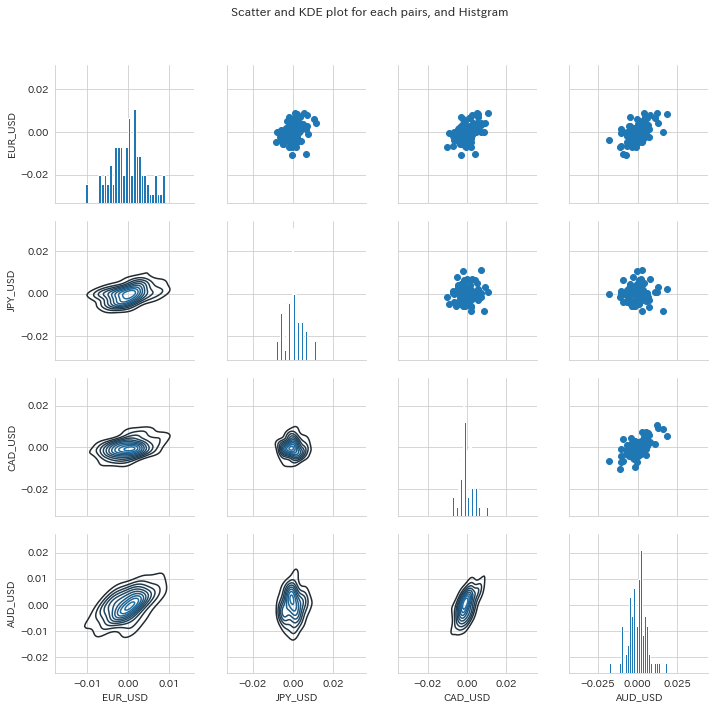

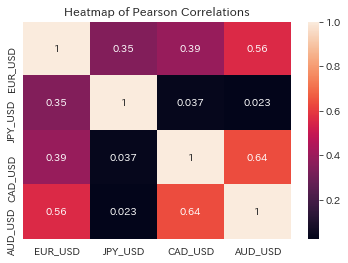

In [6]:
returns_fig = sns.PairGrid(returns_df)

returns_fig.map_upper(plt.scatter)
returns_fig.map_lower(sns.kdeplot)
returns_fig.map_diag(plt.hist,bins=30)

plt.subplots_adjust(top=0.9)
returns_fig.fig.suptitle('Scatter and KDE plot for each pairs, and Histgram')
plt.show()

sns.heatmap(returns_df.corr(), annot=True)
plt.title('Heatmap of Pearson Correlations')
plt.show()

### Insights

- The movements of EUR/AUD and CAD/AUD have stronger correlations than other pairs. The values are 0.56 and 0.64 for each.
- CAD/JPY and AUD/JPY dont't seem to have any correlations.

## Risks and Returns

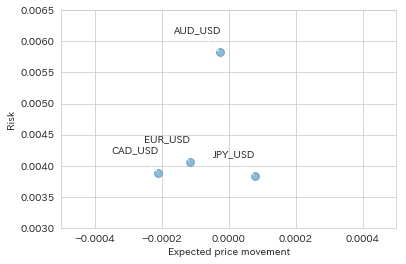

In [7]:
area = np.pi*20

plt.scatter(returns_df.mean(), returns_df.std(),alpha = 0.5,s =area)

# Set the x and y limits of the plot (optional, remove this if you don't see anything in your plot)
plt.xlim([-0.0005,0.0005])
plt.ylim([0.003,0.0065])

#Set the plot axis titles
plt.xlabel('Expected price movement')
plt.ylabel('Risk')

for label, x, y in zip(returns_df.columns, returns_df.mean(), returns_df.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (0, 20),
        textcoords = 'offset points', ha = 'right',
        arrowprops = dict(arrowstyle='-', connectionstyle= 'arc3'))
plt.show()

The price movement of AUD/USD is more active in a day than other currencies.

### Value at Risk

Calculate the expected changing rate in a day.

In [8]:
LOWER_PARCENTILE = 0.05
HIGHER_PARCENTILE = 0.95
MONEY = 10000
for currency_pair in currency_pairs:
    lower = returns_df[currency_pair].quantile(LOWER_PARCENTILE)
    higher = returns_df[currency_pair].quantile(HIGHER_PARCENTILE)
    print('---------------------------')
    print(currency_pair, ':')
    print('{} percentile'.format(LOWER_PARCENTILE*100), ':', lower)
    print('{} percentile'.format(HIGHER_PARCENTILE*100), ':', higher)
    print('{}USD'.format(MONEY), 'will be in the range between', 
          round(MONEY*(1+lower)), 'and', round(MONEY*(1+higher)), 
          'at the end of day by', currency_pair[:3], 'with 90%')

---------------------------
EUR_USD :
5.0 percentile : -0.006686322336416894
95.0 percentile : 0.006932575553966468
10000USD will be in the range between 9933 and 10069 at the end of day by EUR with 90%
---------------------------
JPY_USD :
5.0 percentile : -0.005666176208623664
95.0 percentile : 0.006602584275468558
10000USD will be in the range between 9943 and 10066 at the end of day by JPY with 90%
---------------------------
CAD_USD :
5.0 percentile : -0.006603816537519325
95.0 percentile : 0.0070455721721682345
10000USD will be in the range between 9934 and 10070 at the end of day by CAD with 90%
---------------------------
AUD_USD :
5.0 percentile : -0.00961027951961214
95.0 percentile : 0.008954061912762658
10000USD will be in the range between 9904 and 10090 at the end of day by AUD with 90%


### Simulate Value at Risk by Monte Carlo method based on the Brown Movement model

the brown movement model formulation is below:

```math
\Delta
```

where S, \mu, detone price, mean of price changing, standard deviation, random value, small time span

In [9]:
def monte_carlo_simulation(start_price,days,mu,sigma):
    
    price = np.zeros(days)
    price[0] = start_price

    shock = np.zeros(days)
    drift = np.zeros(days)
    
    dt = 1 / days
    for x in range(1,days):
        shock[x] = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        drift[x] = mu * dt
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))
        
    return price

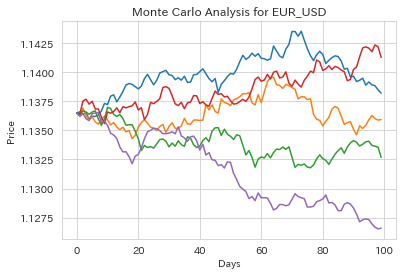

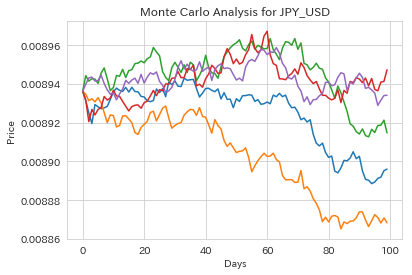

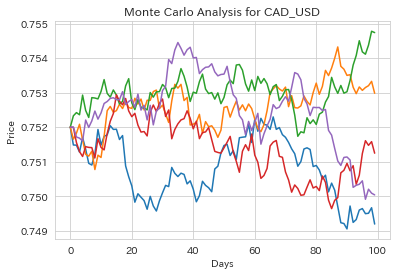

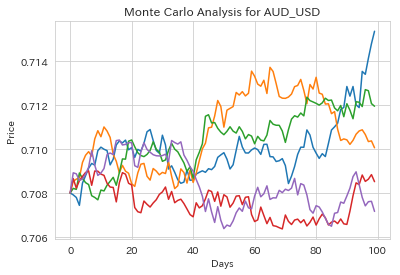

In [10]:
days = 100
for currency_pair in currency_pairs:
    start_price = closing_df[currency_pair][-1]
    mu = returns_df[currency_pair].mean()
    sigma = returns_df[currency_pair].std()

    for run in range(5):
        plt.plot(monte_carlo_simulation(start_price,days,mu,sigma))
    plt.xlabel("Days")
    plt.ylabel("Price")  
    plt.title('Monte Carlo Analysis for ' + currency_pair)
    plt.show()

### Run more simulations for EUR/USD

Run 10000 the simulations and show the distribution of the expected price after 100 days. then we can get the value at risk by numerical simualtion

In [11]:
days = 100
mu = returns_df['EUR_USD'].mean()
sigma = returns_df['EUR_USD'].std()
start_price = closing_df['EUR_USD'][-1]

In [12]:
runs = 10000
results = np.zeros(runs)
for run in range(runs):
    results[run] = monte_carlo_simulation(start_price, days, mu, sigma)[-1]

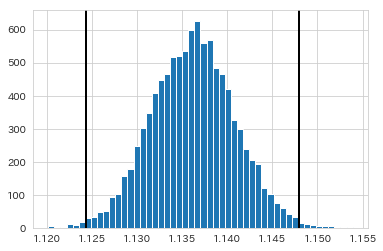

In [14]:
plt.hist(results, bins=50)

lower = np.percentile(results,0.5)
higher = np.percentile(results,99.5)

plt.axvline(x=lower, linewidth=2, color='black')
plt.axvline(x=higher, linewidth=2, color='black')

plt.show()

In [15]:
print('start price:', start_price)
print('0.5% lower plice:', lower)
print('0.5% higher plice:', higher)

start price: 1.13648
0.5% lower plice: 1.1242946554576259
0.5% higher plice: 1.1479048145410014


### Insights

This simulation above shows if the start price of EUR/USD is 1.13648, then the closing price will be in the range between 1.124 and 1.1479 by 99%